Batch prediction acceleration for patches

Overlay of mask on original image

Saving the segmentation as .npy array for later analysis

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#WORKING Single List

In [ ]:
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.saving import register_keras_serializable
from patchify import patchify, unpatchify
import os
from tqdm import tqdm
import sys

In [ ]:
def overlay_mask_on_image(original_img_path, mask, alpha=0.4, mask_color=(255, 0, 0)):
    """
    Overlay a binary mask on the original RGB image.

    Args:
        original_img_path (str): Path to the original RGB image.
        mask (np.array): Binary mask array of shape (H, W), values 0 or 1.
        alpha (float): Transparency of the mask overlay (0=transparent, 1=opaque).
        mask_color (tuple): RGB color for the mask overlay, default red.

    Returns:
        PIL.Image: Image with overlay.
    """
    orig_img = Image.open(original_img_path).convert("RGB")
    orig_arr = np.array(orig_img)

    # Create a color mask image with the same shape as original
    color_mask = np.zeros_like(orig_arr, dtype=np.uint8)
    color_mask[mask == 1] = mask_color  # Apply mask color where mask==1

    # Blend images: result = alpha * mask + (1-alpha) * original
    blended = (orig_arr * (1 - alpha) + color_mask * alpha).astype(np.uint8)

    return Image.fromarray(blended)

In [ ]:
!pip install cellpose==4.0.5
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118  # adjust for your CUDA

Looking in indexes: https://download.pytorch.org/whl/cu118


Loading Cellpose livecell model...
Found 14 images


Segmenting:   0%|          | 0/14 [00:00<?, ?it/s]

15.jpg → 216 cells
Saved binary mask: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_outputs/15.png


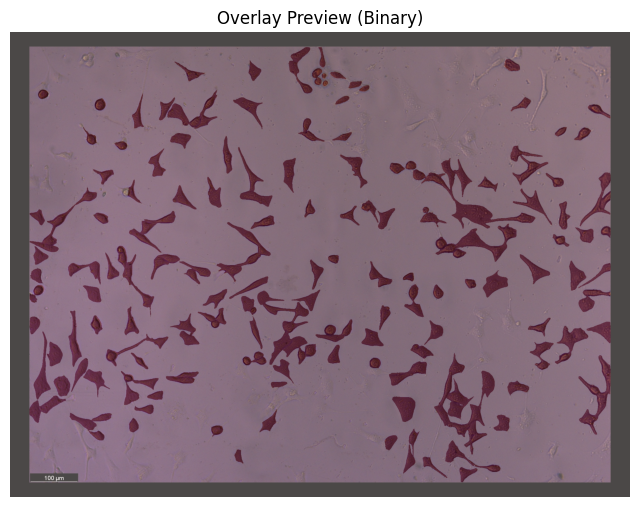

20.jpg → 273 cells
Saved binary mask: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_outputs/20.png


21.jpg → 207 cells
Saved binary mask: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_outputs/21.png


28.jpg → 109 cells
Saved binary mask: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_outputs/28.png


28A.jpg → 210 cells
Saved binary mask: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_outputs/28A.png


29.jpg → 118 cells
Saved binary mask: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_outputs/29.png
33.jpg → 128 cells
Saved binary mask: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_outputs/33.png


34.jpg → 121 cells
Saved binary mask: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_outputs/34.png


35.jpg → 88 cells
Saved binary mask: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_outputs/35.png


37.jpg → 84 cells
Saved binary mask: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_outputs/37.png


41.jpg → 56 cells
Saved binary mask: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_outputs/41.png


42.jpg → 249 cells
Saved binary mask: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_outputs/42.png


44.jpg → 427 cells
Saved binary mask: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_outputs/44.png


50.jpg → 317 cells
Saved binary mask: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_outputs/50.png
✅ All binary masks saved.


In [ ]:
from cellpose import models, io
import os, glob
from tqdm.notebook import tqdm
import numpy as np
from skimage import img_as_ubyte
import matplotlib.pyplot as plt

# Paths
img_dir = "/content/gdrive/MyDrive/Experimental_Results/Comparision_with_other_models/10_Lab_img"
output_dir = "/content/gdrive/MyDrive/Experimental_Results/Comparision_with_other_models/CellPose_SAM_outputs"
os.makedirs(output_dir, exist_ok=True)

# Load model
print("Loading Cellpose livecell model...")
model = models.CellposeModel(gpu=True, pretrained_model="livecell")

# Get files
img_files = sorted(glob.glob(os.path.join(img_dir, "*.png")) + glob.glob(os.path.join(img_dir, "*.jpg")))
print(f"Found {len(img_files)} images")

for idx, img_path in enumerate(tqdm(img_files, desc="Segmenting")):
    img = io.imread(img_path)

    # Segment
    masks, flows, styles = model.eval(
        img, channels=[0, 0],
        diameter=None,
        cellprob_threshold=0.0,
        flow_threshold=0.4
    )

    num_cells = len(np.unique(masks)) - 1
    print(f"{os.path.basename(img_path)} → {num_cells} cells")

    # Convert to binary (255 for cell, 0 for background)
    binary_mask = (masks > 0).astype(np.uint8) * 255
    save_path = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(img_path))[0]}.png")
    io.imsave(save_path, img_as_ubyte(binary_mask))
    print(f"Saved binary mask: {save_path}")

    # Preview for first image
    if idx == 0:
        plt.figure(figsize=(8,8))
        plt.imshow(img, cmap='gray')
        plt.imshow(binary_mask, alpha=0.3, cmap='Reds')
        plt.title("Overlay Preview (Binary)")
        plt.axis('off')
        plt.show()

print("✅ All binary masks saved.")


In [ ]:
import os
import glob
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm



# === Paths ===
img_dir = "/content/gdrive/MyDrive/Experimental_Results/Comparision_with_other_models/10_Lab_img"
mask_dir = "/content/gdrive/MyDrive/Experimental_Results/Comparision_with_other_models/CellPose_SAM_outputs" # binary masks
overlay_dir = "/content/gdrive/MyDrive/Experimental_Results/Comparision_with_other_models/CellPose_SAM_overlays"
os.makedirs(overlay_dir, exist_ok=True)

# === Process all mask files ===
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

for mask_path in tqdm(mask_files, desc="Creating overlays"):
    base_name_no_ext = os.path.splitext(os.path.basename(mask_path))[0]  # name without .png

    # Try to find matching original image (jpg or png)
    possible_exts = [".png", ".jpg", ".jpeg"]
    orig_img_path = None
    for ext in possible_exts:
        test_path = os.path.join(img_dir, base_name_no_ext + ext)
        if os.path.exists(test_path):
            orig_img_path = test_path
            break

    if orig_img_path is None:
        print(f"⚠️ Original image not found for mask: {mask_path}")
        continue

    # Load mask
    mask = np.array(Image.open(mask_path).convert("L"))
    mask = (mask > 0).astype(np.uint8)

    # Create overlay
    overlay_img = overlay_mask_on_image(orig_img_path, mask, alpha=0.4, mask_color=(255, 0, 0))

    # Save overlay with same base name but PNG format
    overlay_path = os.path.join(overlay_dir, base_name_no_ext + ".png")
    overlay_img.save(overlay_path)
    print(f"✅ Saved overlay: {overlay_path}")

print("🎯 All overlays saved to:", overlay_dir)


Creating overlays:   0%|          | 0/14 [00:00<?, ?it/s]

✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_overlays/15.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_overlays/20.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_overlays/21.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_overlays/28.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_overlays/28A.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_overlays/29.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_overlays/33.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose_overlays/34.png
✅ Saved overlay: /conte

Please comment out the code of CellPose-SAM and restart the enviroment when running the cells of Stardist after running the code for CellPose-SAM

In [ ]:
# Install StarDist and dependencies
!pip install stardist csbdeep tifffile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 7.0 MB/s eta 0:00:00


In [ ]:
!pip install numpy==1.26.4

In [ ]:
from skimage.color import rgb2gray
from skimage.util import invert
from csbdeep.utils import normalize
from stardist.models import StarDist2D
import numpy as np
from PIL import Image
import os, glob
from tqdm.notebook import tqdm

# === Paths ===
img_dir = "/content/gdrive/MyDrive/Experimental_Results/Comparision_with_other_models/10_Lab_img"
stardist_output_dir = "/content/gdrive/MyDrive/Experimental_Results/Comparision_with_other_models/StarDist_outputs"

# Make directory
os.makedirs(output_dir, exist_ok=True)

# List images
img_files = sorted(glob.glob(os.path.join(img_dir, "*.png")) + glob.glob(os.path.join(img_dir, "*.jpg")))
print(f"Found {len(img_files)} images.")

# Function to run StarDist on a set of images
def run_stardist(model_name, model, img_files, output_dir):
    for img_path in tqdm(img_files, desc=f"Running StarDist ({model_name})"):
        img = np.array(Image.open(img_path))

        # Handle grayscale or RGB images
        if img.ndim == 3:
            gray = rgb2gray(img)
        else:
            gray = img

        gray_inv = invert(gray)
        img_norm = normalize(gray_inv, 1, 99.8)

        # Predict
        labels, _ = model.predict_instances(img_norm)

        # Binary mask
        binary_mask = (labels > 0).astype(np.uint8) * 255

        # Save
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        mask_path = os.path.join(output_dir, base_name + ".png")
        Image.fromarray(binary_mask).save(mask_path)

        print(f"✅ [{model_name}] Saved: {mask_path}")

# Run StarDist model
model_fluo = StarDist2D.from_pretrained("2D_versatile_fluo")
run_stardist("2D_versatile_fluo", model_fluo, img_files, stardist_output_dir)

print("🎯 StarDist processing completed!")


Found 14 images.
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Running StarDist (2D_versatile_fluo):   0%|          | 0/14 [00:00<?, ?it/s]

functional.py (237): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 1536, 2048, 1))


✅ [2D_versatile_fluo] Saved: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/StarDist_outputs_2D_versatile_fluo/15.png
✅ [2D_versatile_fluo] Saved: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/StarDist_outputs_2D_versatile_fluo/20.png
✅ [2D_versatile_fluo] Saved: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/StarDist_outputs_2D_versatile_fluo/21.png
✅ [2D_versatile_fluo] Saved: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/StarDist_outputs_2D_versatile_fluo/28.png
✅ [2D_versatile_fluo] Saved: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/StarDist_outputs_2D_versatile_fluo/28A.png
✅ [2D_versatile_fluo] Saved: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/StarDist_outputs_2D_versatile_fluo/29.png
✅ [2D_versatile_fluo] Saved: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_c

Padding → Left: 64, Right: 64, Top: 68, Bottom: 68


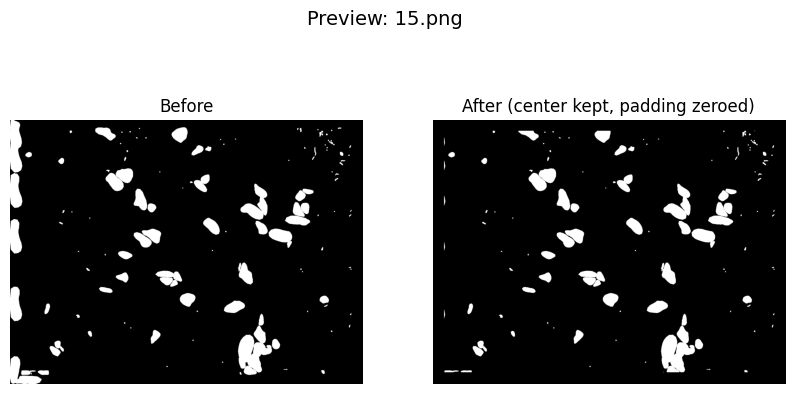

Zeroing symmetric padding:   0%|          | 0/14 [00:00<?, ?it/s]

✅ All masks updated.


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os, glob
from tqdm.notebook import tqdm

# Original unpadded dimensions
orig_w, orig_h = 1920, 1400
# Padded final dimensions
pad_w, pad_h = 2048, 1536

# Calculate symmetric padding
pad_left = (pad_w - orig_w) // 2
pad_right = pad_w - orig_w - pad_left
pad_top = (pad_h - orig_h) // 2
pad_bottom = pad_h - orig_h - pad_top

print(f"Padding → Left: {pad_left}, Right: {pad_right}, Top: {pad_top}, Bottom: {pad_bottom}")

mask_files = sorted(glob.glob(os.path.join(stardist_output_dir, "*.png")))

# Preview on first mask
sample_mask_path = mask_files[0]
mask = np.array(Image.open(sample_mask_path).convert("L"))
preview_mask = mask.copy()

# Zero out padding regions
preview_mask[:pad_top, :] = 0
preview_mask[-pad_bottom:, :] = 0
preview_mask[:, :pad_left] = 0
preview_mask[:, -pad_right:] = 0

# Show before/after
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(mask, cmap="gray")
plt.title("Before")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(preview_mask, cmap="gray")
plt.title("After (center kept, padding zeroed)")
plt.axis("off")

plt.suptitle(f"Preview: {os.path.basename(sample_mask_path)}", fontsize=14)
plt.show()

# Auto-confirm in Colab
proceed = True  # set False to cancel

if proceed:
    for mask_path in tqdm(mask_files, desc="Zeroing symmetric padding"):
        m = np.array(Image.open(mask_path).convert("L"))
        m[:pad_top, :] = 0
        m[-pad_bottom:, :] = 0
        m[:, :pad_left] = 0
        m[:, -pad_right:] = 0
        Image.fromarray(m).save(mask_path)
    print("✅ All masks updated.")
else:
    print("❌ Operation cancelled.")

In [ ]:
import os
import glob
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

# === Paths ===
img_dir = "/content/gdrive/MyDrive/Experimental_Results/Comparision_with_other_models/10_Lab_img"  # original images
mask_dir = "/content/gdrive/MyDrive/Experimental_Results/Comparision_with_other_models/StarDist_outputs"  # binary masks
overlay_dir = "/content/gdrive/MyDrive/Experimental_Results/Comparision_with_other_models/StarDist_overlays"
os.makedirs(overlay_dir, exist_ok=True)

# === Process all mask files ===
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

for mask_path in tqdm(mask_files, desc="Creating overlays"):
    base_name_no_ext = os.path.splitext(os.path.basename(mask_path))[0]  # name without .png

    # Try to find matching original image (jpg or png)
    possible_exts = [".png", ".jpg", ".jpeg"]
    orig_img_path = None
    for ext in possible_exts:
        test_path = os.path.join(img_dir, base_name_no_ext + ext)
        if os.path.exists(test_path):
            orig_img_path = test_path
            break

    if orig_img_path is None:
        print(f"⚠️ Original image not found for mask: {mask_path}")
        continue

    # Load mask
    mask = np.array(Image.open(mask_path).convert("L"))
    mask = (mask > 0).astype(np.uint8)

    # Create overlay
    overlay_img = overlay_mask_on_image(orig_img_path, mask, alpha=0.4, mask_color=(255, 0, 0))

    # Save overlay with same base name but PNG format
    overlay_path = os.path.join(overlay_dir, base_name_no_ext + ".png")
    overlay_img.save(overlay_path)
    print(f"✅ Saved overlay: {overlay_path}")

print("🎯 All overlays saved to:", overlay_dir)


Creating overlays:   0%|          | 0/14 [00:00<?, ?it/s]

✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/StarDist_overlays/15.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/StarDist_overlays/20.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/StarDist_overlays/21.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/StarDist_overlays/28.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/StarDist_overlays/28A.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/StarDist_overlays/29.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/StarDist_overlays/33.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/StarDist_overlays/34.png
✅ Saved overlay: /conte

In [ ]:
!pip install cellpose==3.1.1.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.9/225.9 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from cellpose import models, io
import os, glob
import numpy as np
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Loading Cellpose 3 model...


100%|██████████| 25.3M/25.3M [00:02<00:00, 9.30MB/s]


Found 14 images


Segmenting with Cellpose 3:   0%|          | 0/14 [00:00<?, ?it/s]

15.jpg → 113 cells


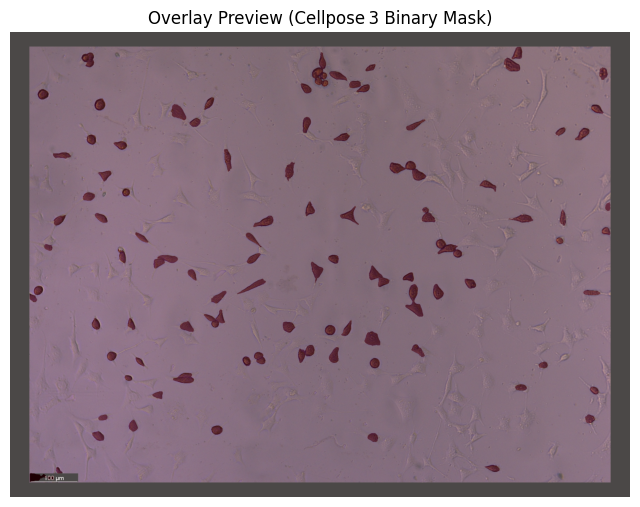

20.jpg → 105 cells
21.jpg → 179 cells
28.jpg → 54 cells
28A.jpg → 118 cells
29.jpg → 96 cells
33.jpg → 46 cells
34.jpg → 64 cells
35.jpg → 59 cells
37.jpg → 198 cells
41.jpg → 287 cells
42.jpg → 81 cells
44.jpg → 82 cells
50.jpg → 73 cells
✅ All binary masks saved (Cellpose 3).


In [ ]:
# Paths
img_dir = "/content/gdrive/MyDrive/Experimental_Results/Comparision_with_other_models/10_Lab_img"
output_dir = "/content/gdrive/MyDrive/Experimental_Results/Comparision_with_other_models/CellPose3_outputs"
os.makedirs(output_dir, exist_ok=True)

# Load CellposeModel (Cellpose 3 uses the cyto3 model under the hood)
print("Loading Cellpose 3 model...")
model = models.CellposeModel(gpu=True, pretrained_model="cyto3")

# Collect image files
img_files = sorted(glob.glob(os.path.join(img_dir, "*.png")) + glob.glob(os.path.join(img_dir, "*.jpg")))
print(f"Found {len(img_files)} images")

for idx, img_path in enumerate(tqdm(img_files, desc="Segmenting with Cellpose 3")):
    img = io.imread(img_path)

    # If you have grayscale images, convert them to shape (2, H, W)
    # Both channels 0 will treat as single-channel input
    masks, flows, styles = model.eval(
        img, channels=[0, 0],
        diameter=None,
        cellprob_threshold=0.0,
        flow_threshold=0.4
    )

    num_cells = len(np.unique(masks)) - 1
    print(f"{os.path.basename(img_path)} → {num_cells} cells")

    # Save binary mask
    binary = (masks > 0).astype(np.uint8) * 255
    save_path = os.path.join(output_dir, os.path.basename(img_path))
    io.imsave(save_path, img_as_ubyte(binary))

    if idx == 0:
        plt.figure(figsize=(8,8))
        plt.imshow(img, cmap='gray')
        plt.imshow(binary, alpha=0.3, cmap='Reds')
        plt.title("Overlay Preview (Cellpose 3 Binary Mask)")
        plt.axis('off')
        plt.show()

print("✅ All binary masks saved (Cellpose 3).")

In [ ]:
import os
import glob
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm


# === Paths ===
img_dir = "/content/gdrive/MyDrive/Experimental_Results/Comparision_with_other_models/10_Lab_img"  # original images
mask_dir = "/content/gdrive/MyDrive/Experimental_Results/Comparision_with_other_models/CellPose3_outputs"  # binary masks
overlay_dir = "/content/gdrive/MyDrive/Experimental_Results/Comparision_with_other_models/CellPose3_overlays"
os.makedirs(overlay_dir, exist_ok=True)

# === Process all mask files ===
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.jpg")))

for mask_path in tqdm(mask_files, desc="Creating overlays"):
    base_name_no_ext = os.path.splitext(os.path.basename(mask_path))[0]  # name without .png

    # Try to find matching original image (jpg or png)
    possible_exts = [".png", ".jpg", ".jpeg"]
    orig_img_path = None
    for ext in possible_exts:
        test_path = os.path.join(img_dir, base_name_no_ext + ext)
        if os.path.exists(test_path):
            orig_img_path = test_path
            break

    if orig_img_path is None:
        print(f"⚠️ Original image not found for mask: {mask_path}")
        continue

    # Load mask
    mask = np.array(Image.open(mask_path).convert("L"))
    mask = (mask > 0).astype(np.uint8)

    # Create overlay
    overlay_img = overlay_mask_on_image(orig_img_path, mask, alpha=0.4, mask_color=(255, 0, 0))

    # Save overlay with same base name but PNG format
    overlay_path = os.path.join(overlay_dir, base_name_no_ext + ".png")
    overlay_img.save(overlay_path)
    print(f"✅ Saved overlay: {overlay_path}")

print("🎯 All overlays saved to:", overlay_dir)

Creating overlays:   0%|          | 0/14 [00:00<?, ?it/s]

✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose3_overlays/15.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose3_overlays/20.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose3_overlays/21.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose3_overlays/28.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose3_overlays/28A.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose3_overlays/29.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose3_overlays/33.png
✅ Saved overlay: /content/gdrive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/CellPose3_overlays/34.png
✅ Saved overlay